# Titanic Dataset - Feature Engineering

**Student:** Arthur Gislon Leonida

**Objective:** This dataset aims to predict the survival of passengers on the Titanic.

**Dataset URL:** https://www.kaggle.com/competitions/titanic

**Data Dictionary:**

* **survival:** Survival (0 = No, 1 = Yes) - That's the **TARGET**

* **pclass:** Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)

* **sex:** Sex	

* **Age:** Age in years	

* **sibsp:** # of siblings / spouses aboard the Titanic	

* **parch:** # of parents / children aboard the Titanic	

* **ticket:**	Ticket number	

* **fare:** Passenger fare	

* **cabin:** Cabin number	

* **embarked:** Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [72]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import shap
import ipykernel
from scipy.stats import boxcox
from helper_functions import adaptive_binning, robust_outlier_detection, mutual_information, hsic
from sklearn import set_config
import optuna as opt

# This tells all scikit-learn transformers to output pandas DataFrames
set_config(transform_output="pandas")

print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("sklearn version:", sklearn.__version__)
print("xgboost version:", xgb.__version__)
print("numpy version:", np.__version__)
print("shap version:", shap.__version__)
print("optuna version:", opt.__version__)
print("ipykernel version:", ipykernel.__version__)
print('python version:', os.popen('python --version').read().strip())

pandas version: 2.3.2
matplotlib version: 3.10.5
seaborn version: 0.13.2
sklearn version: 1.7.1
xgboost version: 3.0.4
numpy version: 2.2.0
shap version: 0.48.0
optuna version: 4.5.0
ipykernel version: 6.30.1
python version: Python 3.13.7


In [73]:
features_description = {
    'PassengerId': 'Passenger ID',
    'Survived': 'Survival (0 = No; 1 = Yes)',
    'Pclass': 'Passenger Class (1st, 2nd, 3rd)',
    'Name': 'Passenger Name',
    'Sex': 'Gender',
    'Age': 'Age in years',
    'SibSp': 'Number of Siblings/Spouses Aboard',
    'Parch': 'Number of Parents/Children Aboard',
    'Ticket': 'Ticket Number',
    'Fare': 'Passenger Fare',
    'Cabin': 'Cabin Number',
    'Embarked': 'Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)'
}

In [74]:
# The downloaded dataset has a file named 'Salary Prediction of Data Professions.csv'
train_file_path = 'data/train.csv'
# test_file_path = 'data/test.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(train_file_path)
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Survived'])

# I won't use this because it doesn't have the target variable (it was made for kaggle competition)
# test_df = pd.read_csv(test_file_path)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [75]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Creating some classes for imputation

I used a little bit of this video as reference: https://www.youtube.com/watch?v=fATVVQfFyU0

In [76]:
# 1. Define which columns are which type
numeric_features = []
categorical_features = []
for col in df_train.drop('Survived', axis=1).columns:
    # check col type
    if df_train[col].dtype == 'object':
        categorical_features.append(col)
    else:    
        numeric_features.append(col)

# 2. Create the preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 3. Combine preprocessing steps into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # This ensures columns like 'Name', 'Ticket', and 'Cabin' are dropped
)

# 4. Create the final, simple baseline pipeline
baseline_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

## Baseline Model

In [77]:
X_train_base = df_train.drop('Survived', axis=1)
y_train_base = df_train['Survived']
X_val_base = df_val.drop('Survived', axis=1)
y_val_base = df_val['Survived']

X_train_base_processed = baseline_pipeline.fit_transform(X_train_base)
X_val_base_processed = baseline_pipeline.transform(X_val_base)

In [78]:
# Train baseline model
baseline_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
baseline_model.fit(X_train_base_processed, y_train_base)

# Evaluate baseline model
preds_base = baseline_model.predict(X_val_base_processed)
baseline_accuracy = accuracy_score(y_val_base, preds_base)

print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")

Baseline Model Accuracy: 0.7263


## Tune Baseline Model

In [79]:
def objective(trial, X_train, y_train, X_val, y_val):
    """
    The objective function for Optuna to optimize.
    A 'trial' is a single run with a specific set of hyperparameters.
    """
    # Suggest hyperparameters for XGBoost
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 1, 10), # L2 regularization
        'alpha': trial.suggest_float('alpha', 0, 10),    # L1 regularization
        'random_state': 42
    }

    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    preds = model.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy

In [80]:
study = opt.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_base_processed, y_train_base, X_val_base_processed, y_val_base), n_trials=100)

print("\nBest hyperparameters found:")
print(study.best_params)

print("\nBest Accuracy on the test set:")
print(study.best_value)

[I 2025-09-09 02:16:58,088] A new study created in memory with name: no-name-6ae23b6c-7666-45b1-ae3b-6a88022badea
[I 2025-09-09 02:17:02,076] Trial 0 finished with value: 0.8100558659217877 and parameters: {'n_estimators': 600, 'learning_rate': 0.09004683047170382, 'max_depth': 8, 'subsample': 0.7066263769960884, 'colsample_bytree': 0.6423132200134126, 'gamma': 0.7276041155561197, 'lambda': 6.908104546267322, 'alpha': 6.494462487398604}. Best is trial 0 with value: 0.8100558659217877.
[I 2025-09-09 02:17:04,525] Trial 1 finished with value: 0.7988826815642458 and parameters: {'n_estimators': 300, 'learning_rate': 0.06432256493378899, 'max_depth': 3, 'subsample': 0.6878472030468967, 'colsample_bytree': 0.7161689309705804, 'gamma': 3.991258624554717, 'lambda': 5.808255526258043, 'alpha': 5.5854052417621265}. Best is trial 0 with value: 0.8100558659217877.
[I 2025-09-09 02:17:09,802] Trial 2 finished with value: 0.7932960893854749 and parameters: {'n_estimators': 800, 'learning_rate': 0.0


Best hyperparameters found:
{'n_estimators': 400, 'learning_rate': 0.025556744452506348, 'max_depth': 6, 'subsample': 0.6336509701387867, 'colsample_bytree': 0.6088273359939392, 'gamma': 3.8268337858655146, 'lambda': 7.2523162154228995, 'alpha': 0.29289716784674735}

Best Accuracy on the test set:
0.8379888268156425


In [100]:
# Train baseline model
baseline_model_tuned = xgb.XGBClassifier(
    n_estimators=study.best_params['n_estimators'],
    learning_rate=study.best_params['learning_rate'],
    max_depth=study.best_params['max_depth'],
    subsample=study.best_params['subsample'],
    colsample_bytree=study.best_params['colsample_bytree'],
    gamma=study.best_params['gamma'],
    lambda_=study.best_params['lambda'],
    alpha=study.best_params['alpha'],
    random_state=42,
    eval_metric='logloss'
)

baseline_model_tuned.fit(X_train_base_processed, y_train_base)

# Evaluate baseline model
preds_base = baseline_model_tuned.predict(X_val_base_processed)
baseline_tuned_accuracy = accuracy_score(y_val_base, preds_base)

print(f"Baseline Tuned Model Accuracy: {baseline_tuned_accuracy:.4f}")

c:\Users\arthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:27:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "lambda_" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Baseline Tuned Model Accuracy: 0.8212



SHAP with Baseline Model Summary Plot:


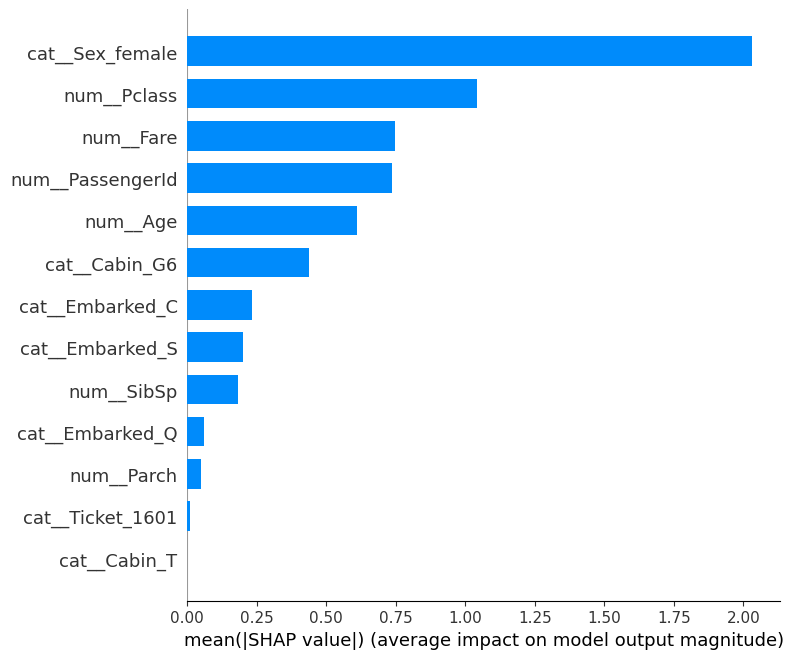

In [112]:
explainer = shap.Explainer(baseline_model, X_train_base_processed)
shap_values = explainer(X_val_base_processed)
print(f"\nSHAP with Baseline Model Summary Plot:")
shap.summary_plot(shap_values, X_val_base_processed, plot_type="bar", max_display=13)


SHAP with Tuned Baseline Model Summary Plot:


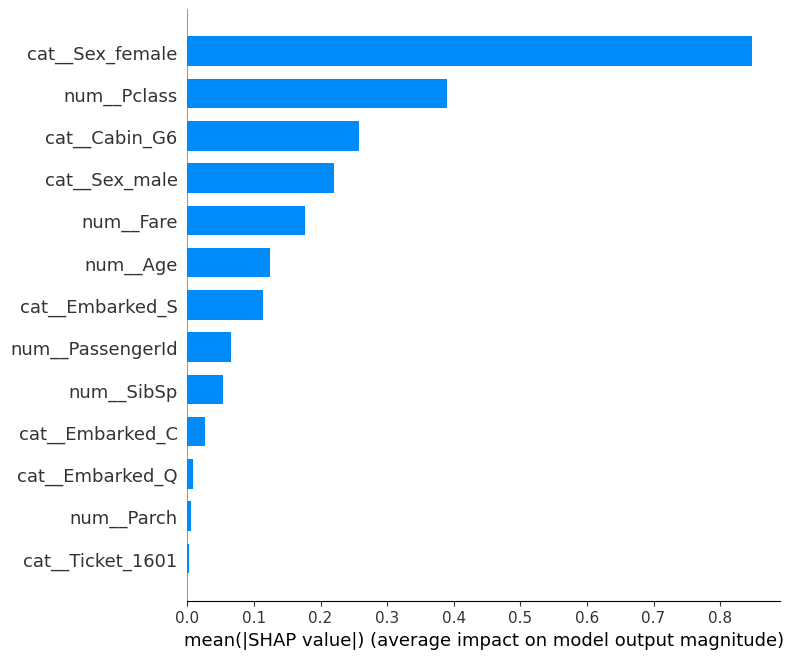

In [113]:
explainer = shap.Explainer(baseline_model_tuned, X_train_base_processed)
shap_values = explainer(X_val_base_processed)
print(f"\nSHAP with Tuned Baseline Model Summary Plot:")
shap.summary_plot(shap_values, X_val_base_processed, plot_type="bar", max_display=13)

# FEATURE ENGINEERING PIPELINE

In [81]:
class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        imputer = SimpleImputer(strategy='mean')
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

class EmbarkedImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy='most_frequent')
        X['Embarked'] = imputer.fit_transform(X[['Embarked']])
        return X

class TitleExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Title'] = X['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
        common_titles = ['Mr', 'Miss', 'Mrs', 'Master']
        X['Title'] = X['Title'].apply(lambda x: x if x in common_titles else 'Other')
        return X

class CabinExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
       # Fill missing cabins with 'U' for 'Unknown'
        cabins = X['Cabin'].fillna('U')
        
        # Extract the first letter as Cabin Deck
        X['CabinDeck'] = cabins.str[0]
        
        # Count the number of cabins (your logic was already correct)
        X['CabinCount'] = X['Cabin'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

        return X

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): 
        return self

    def transform(self, X):
        # Encode Embarked as a single integer column
        embarked_mapping = {'C': 0, 'Q': 1, 'S': 2}
        X['Embarked'] = X['Embarked'].map(embarked_mapping)

        # Encode Sex as a single integer column
        sex_mapping = {'female': 0, 'male': 1}
        X['Sex'] = X['Sex'].map(sex_mapping)

        # Encode Title as a single integer column
        title_mapping = {'Miss': 0, 'Mr': 1, 'Mrs': 2, 'Master': 3, 'Other': 4}
        X['Title'] = X['Title'].map(title_mapping)

        # Encode CabinDeck as a single integer column
        cabin_deck_mapping = {deck: idx for idx, deck in enumerate(X['CabinDeck'].unique())}
        X['CabinDeck'] = X['CabinDeck'].map(cabin_deck_mapping)

        return X

class FeatureScaler(BaseEstimator, TransformerMixin):
    """Applies StandardScaler to all numerical columns."""
    def __init__(self):
        self.scaler = StandardScaler()
        self.numerical_cols = []

    def fit(self, X, y=None):
        # Identify numerical columns to be scaled
        self.numerical_cols = X.drop('Survived', axis=1).select_dtypes(include=np.number).columns.tolist()
        if self.numerical_cols:
            self.scaler.fit(X[self.numerical_cols])
        return self

    def transform(self, X):
        if self.numerical_cols:
            X[self.numerical_cols] = self.scaler.transform(X[self.numerical_cols])
        return X

class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X):
        return X.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, errors='ignore')

In [82]:
pipeline = Pipeline(steps=[
    ('age_imputer', AgeImputer()),
    ('embarked_imputer', EmbarkedImputer()),
    ('title_extractor', TitleExtractor()),
    ('cabin_extractor', CabinExtractor()),
    ('feature_encoder', FeatureEncoder()),
  # ('feature_scaler', FeatureScaler()),
    ('feature_dropper', FeatureDropper())
])

# Create copies for the next feature engineering steps
df_eng_train = df_train.copy()
df_eng_val = df_val.copy()

df_eng_train = pipeline.fit_transform(df_eng_train)
df_eng_val = pipeline.transform(df_eng_val)

c:\Users\arthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [83]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [84]:
df_eng_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,CabinDeck,CabinCount
692,1,3,1,29.807687,0,0,56.4958,2,1,0,0
481,0,2,1,29.807687,0,0,0.0000,2,1,0,0
527,0,1,1,29.807687,0,0,221.7792,2,1,1,1
855,1,3,0,18.000000,0,1,9.3500,2,2,0,0
801,1,2,0,31.000000,1,1,26.2500,2,2,0,0


In [85]:
features = df_eng_train.drop(['Survived'], axis=1)
features.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,CabinDeck,CabinCount
692,3,1,29.807687,0,0,56.4958,2,1,0,0
481,2,1,29.807687,0,0,0.0000,2,1,0,0
527,1,1,29.807687,0,0,221.7792,2,1,1,1
855,3,0,18.000000,0,1,9.3500,2,2,0,0
801,2,0,31.000000,1,1,26.2500,2,2,0,0


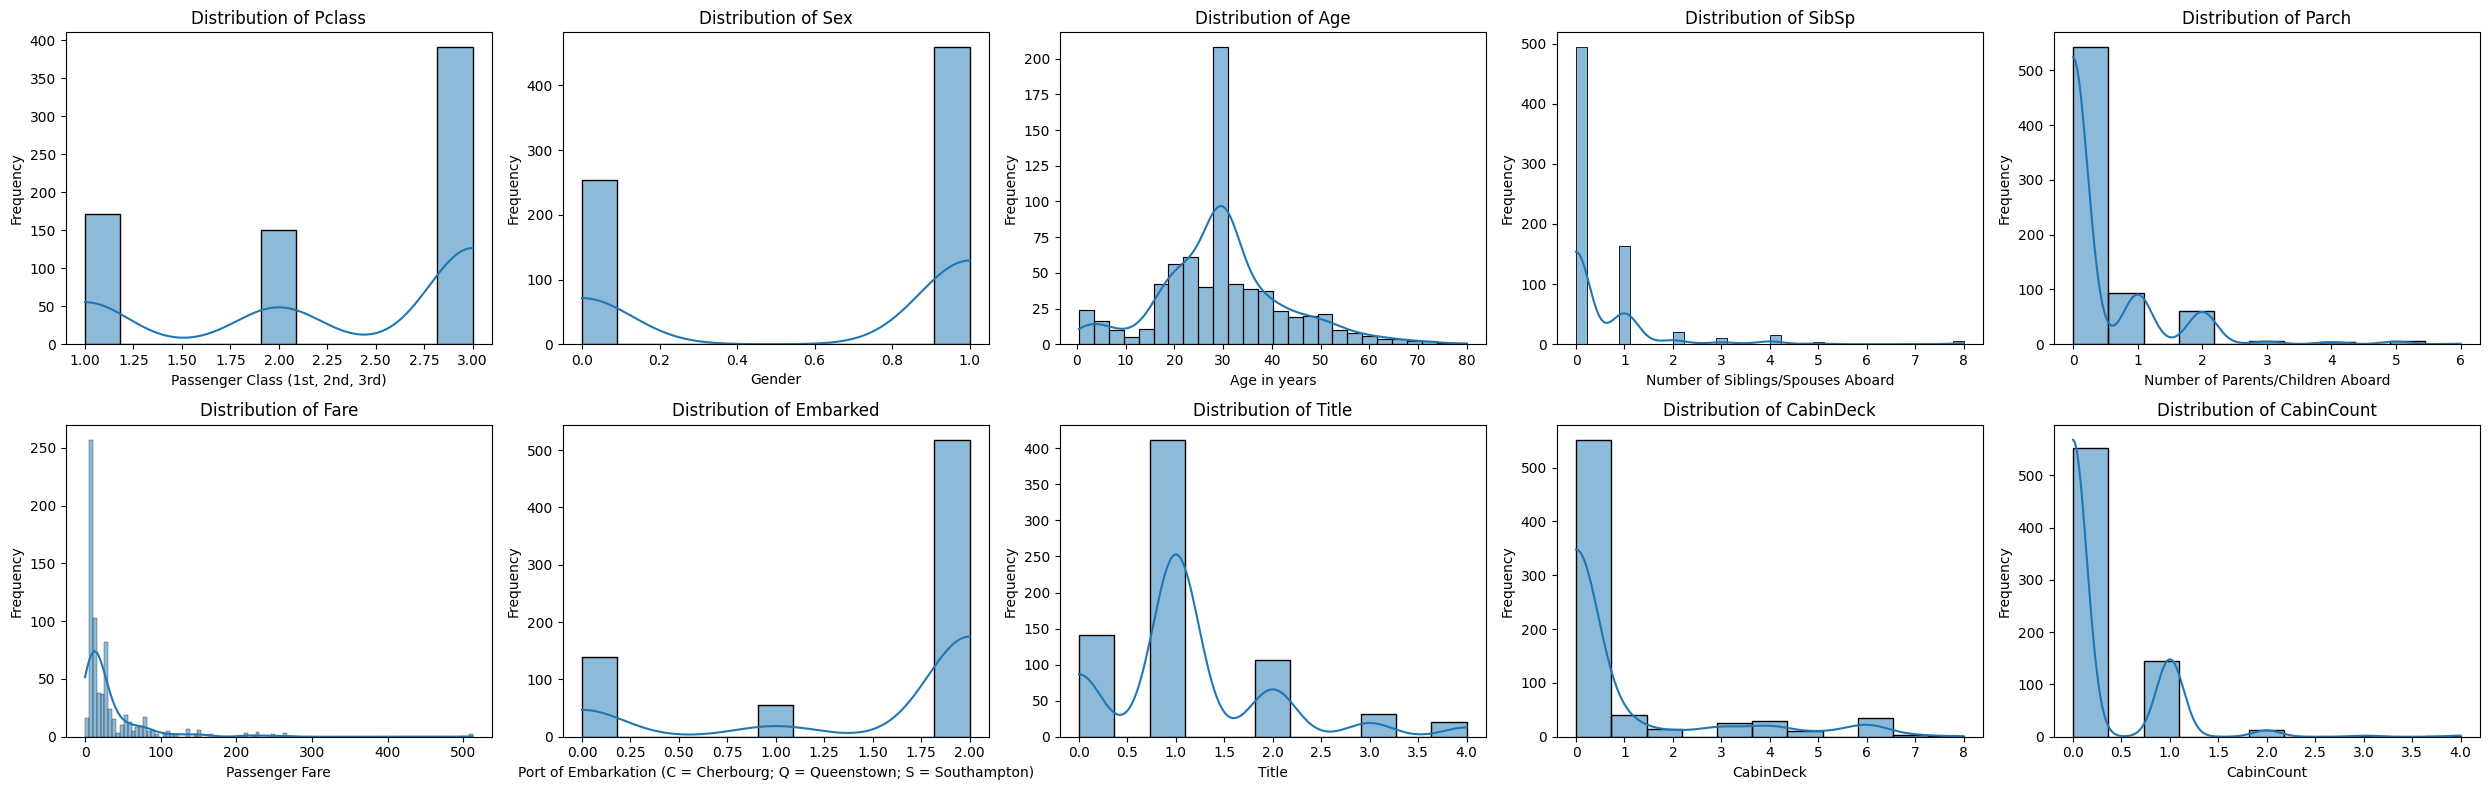

In [86]:
numeric_features = features.select_dtypes(include=['number']).columns
num_plots = len(numeric_features)
cols = 5
rows = (num_plots + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(numeric_features):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(df_eng_train[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(features_description.get(feature, feature))
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [87]:
numerical_features = df_eng_train.select_dtypes(include=np.number).columns
skewness = df_eng_train[numerical_features].skew().sort_values(ascending=False)

print("Skewness of Numerical Features:")
print(skewness)

# Identify highly skewed features
highly_skewed = skewness[abs(skewness) > 0.5]
print("\nFeatures with significant skew:")
print(highly_skewed)

Skewness of Numerical Features:
Fare          4.646190
SibSp         3.815617
Parch         2.842562
CabinCount    2.545818
CabinDeck     2.195185
Title         1.181335
Survived      0.480519
Age           0.392903
Sex          -0.605783
Pclass       -0.630589
Embarked     -1.253597
dtype: float64

Features with significant skew:
Fare          4.646190
SibSp         3.815617
Parch         2.842562
CabinCount    2.545818
CabinDeck     2.195185
Title         1.181335
Sex          -0.605783
Pclass       -0.630589
Embarked     -1.253597
dtype: float64


In [88]:
highly_skewed_features = skewness[(abs(skewness) > 1.5)].index.tolist()
print("\nTop 3 highly skewed features:", highly_skewed_features)

moderate_skewed_features = skewness[(abs(skewness) > 1) & (abs(skewness) <= 1.5)].index.tolist()
print("\nModerately skewed features:", moderate_skewed_features)


Top 3 highly skewed features: ['Fare', 'SibSp', 'Parch', 'CabinCount', 'CabinDeck']

Moderately skewed features: ['Title', 'Embarked']


In [89]:
for feature in numeric_features:
    print(f"Feature: {feature}, Min: {df_eng_train[feature].min()}, Max: {df_eng_train[feature].max()}, Skewness: {skewness[feature]}")

Feature: Pclass, Min: 1, Max: 3, Skewness: -0.6305889933530613
Feature: Sex, Min: 0, Max: 1, Skewness: -0.6057829774753115
Feature: Age, Min: 0.42, Max: 80.0, Skewness: 0.3929032564092265
Feature: SibSp, Min: 0, Max: 8, Skewness: 3.815616890290602
Feature: Parch, Min: 0, Max: 6, Skewness: 2.8425616406990657
Feature: Fare, Min: 0.0, Max: 512.3292, Skewness: 4.64618995113625
Feature: Embarked, Min: 0, Max: 2, Skewness: -1.2535966557689548
Feature: Title, Min: 0, Max: 4, Skewness: 1.1813352313568966
Feature: CabinDeck, Min: 0, Max: 8, Skewness: 2.1951847557963102
Feature: CabinCount, Min: 0, Max: 4, Skewness: 2.5458179262975302


**Fare:** Box-Cox since is continuous and have only positive numbers.

**Other features:** log1p (to include zeros) because they are all right skewed.


In [90]:
# Apply Box-Cox transformation
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    """
    Applies the Box-Cox transformation to a list of specified numerical columns.
    """
    def __init__(self, features=None):
        # Store the list of feature names to be transformed
        self.features = features
        self.lambdas_ = {}

    def fit(self, X, y=None):
        # Learn the optimal lambda for each feature from the training data
        for feature in self.features:
            feature_data = X[feature] + 1  # Box-Cox requires positive values
            _, self.lambdas_[feature] = boxcox(feature_data)
        return self

    def transform(self, X):
        for feature in self.features:
            feature_data = X[feature] + 1
            # Apply the transformation using the lambda learned during fit
            X[feature] = boxcox(feature_data, lmbda=self.lambdas_[feature])
        return X

# Apply log1p transformation
def apply_log_transform(X):
    """Applies a log1p transformation."""
    return np.log1p(X)

In [91]:
features_to_bc_transform = ['Fare']
features_to_log_transform = ['SibSp', 'Parch', 'CabinCount']

preprocessor = ColumnTransformer(
    transformers=[
        ('log_transformer', FunctionTransformer(apply_log_transform), features_to_log_transform),
        ('boxcox_transformer', BoxCoxTransformer(features=features_to_bc_transform), features_to_bc_transform)
    ],
    remainder='passthrough' # Keep other columns ('Age')
)

transform_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

df_eng_train = transform_pipeline.fit_transform(df_eng_train)
df_eng_val = transform_pipeline.transform(df_eng_val)

df_eng_train.columns = df_eng_train.columns.str.replace('remainder__', '').str.replace('log_transformer__', 'log_transformer_').str.replace('boxcox_transformer__', 'boxcox_transformer_')
df_eng_val.columns = df_eng_val.columns.str.replace('remainder__', '').str.replace('log_transformer__', 'log_transformer_').str.replace('boxcox_transformer__', 'boxcox_transformer_')

df_eng_train.head()

,log_transformer_SibSp,log_transformer_Parch,log_transformer_CabinCount,boxcox_transformer_Fare,Survived,Pclass,Sex,Age,Embarked,Title,CabinDeck
692,0.000000,0.000000,0.000000,3.486357,1,3,1,29.807687,2,1,0
481,0.000000,0.000000,0.000000,0.000000,0,2,1,29.807687,2,1,0
527,0.000000,0.000000,0.693147,4.431708,0,1,1,29.807687,2,1,1
855,0.000000,0.693147,0.000000,2.140875,1,3,0,18.000000,2,2,0
801,0.693147,0.693147,0.000000,2.922005,1,2,0,31.000000,2,2,0


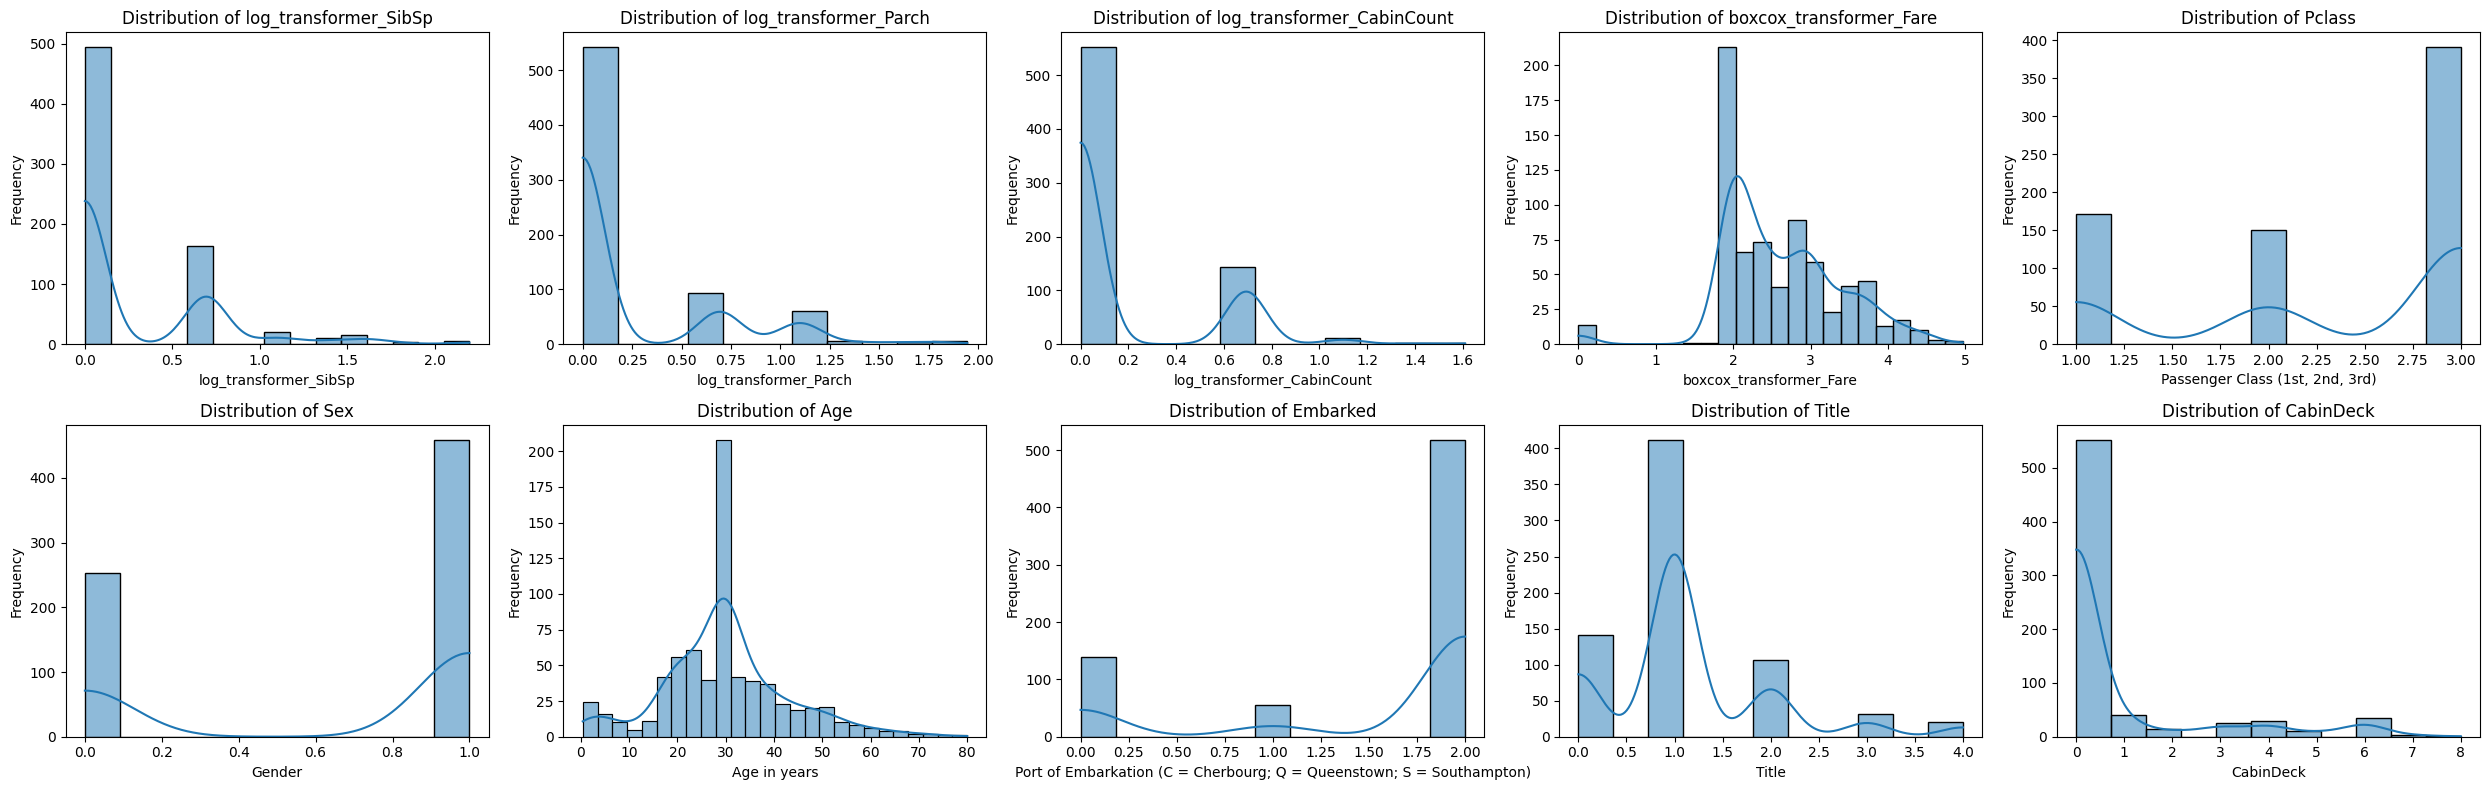

In [92]:
numeric_features = df_eng_train.drop(columns=['Survived']).select_dtypes(include=['number']).columns
num_plots = len(numeric_features)
cols = 5
rows = (num_plots + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(numeric_features):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(df_eng_train[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(features_description.get(feature, feature))
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [93]:
for feature in df_eng_train.drop('Survived', axis=1).select_dtypes(include=['number']).columns:
    # print(f"Processing feature: {feature}")
    outliers = robust_outlier_detection(df_eng_train[feature])
    num_outliers = outliers.sum()
    if num_outliers > 0:
        print(f'Feature "{feature}" has {num_outliers} outliers detected.')

Feature "log_transformer_SibSp" has 8 outliers detected.
Feature "log_transformer_Parch" has 10 outliers detected.
Feature "log_transformer_CabinCount" has 4 outliers detected.
Feature "boxcox_transformer_Fare" has 16 outliers detected.
Feature "Age" has 6 outliers detected.
Feature "Title" has 21 outliers detected.
Feature "CabinDeck" has 39 outliers detected.


Capping 'boxcox_transformer_Fare' at fences: [0.46, 4.60]
Capping 'Age' at fences: [1.00, 57.00]


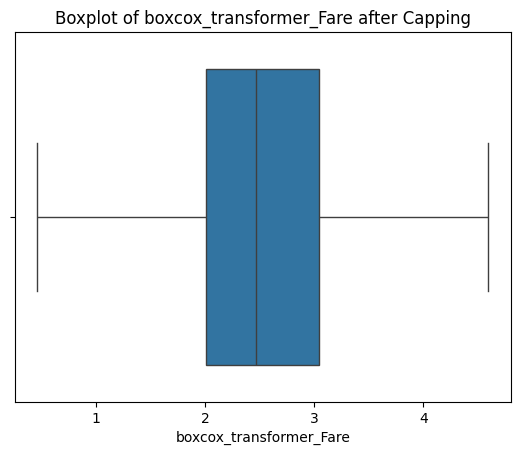

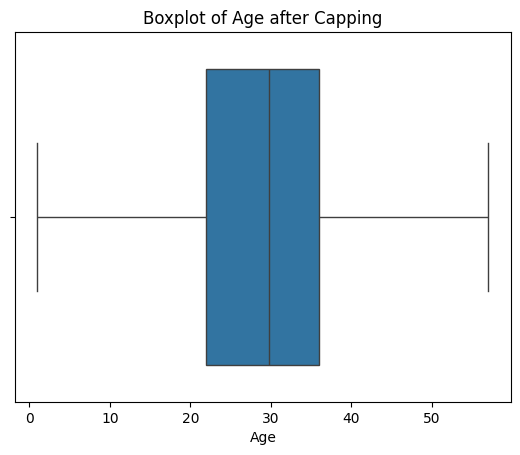

In [94]:
# Focus on the true numerical/continuous features from the list.
features_to_cap = ['boxcox_transformer_Fare', 'Age']

for feature in features_to_cap:
    if feature in df_eng_train.columns:
        # Define bounds using ONLY the training data
        Q1 = df_eng_train[feature].quantile(0.25)
        Q3 = df_eng_train[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_fence = Q1 - 1.5 * IQR
        upper_fence = Q3 + 1.5 * IQR
        
        print(f"Capping '{feature}' at fences: [{lower_fence:.2f}, {upper_fence:.2f}]")
        
        # Apply capping to both training and validation sets
        df_eng_train[feature] = np.clip(df_eng_train[feature], lower_fence, upper_fence)
        df_eng_val[feature] = np.clip(df_eng_val[feature], lower_fence, upper_fence)

for feature in features_to_cap:
    sns.boxplot(x=df_eng_train[feature])
    plt.title(f'Boxplot of {feature} after Capping')
    plt.show()

Consolidate all feature engineering into a single, reusable function.


## Feature Selection

In [95]:
def train_model(X_train, y_train, X_val, y_val):
    final_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    '''
    final_model = xgb.XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        max_depth=4,  # Limit tree depth to prevent overfitting
        gamma=0.1      # Add a regularization term
    )
    '''
    final_model.fit(X_train, y_train)
    preds_final = final_model.predict(X_val)
    final_accuracy = accuracy_score(y_val, preds_final)

    return final_accuracy, final_model

In [108]:
df_selection = df_eng_train.copy().drop(columns=['Survived'])
y_selection = df_eng_train['Survived'].copy()

# Calculate scores
mi_scores = df_selection.apply(lambda x: mutual_information(x, y_selection), axis=0)
hsic_scores = df_selection.apply(lambda x: hsic(x, y_selection), axis=0)

# Select top-k features
scores_df = pd.DataFrame({'MI': mi_scores, 'HSIC': hsic_scores}).sort_values(by='MI', ascending=False)

# --- Loop to Find Best Features ---
best_accuracy = 0
best_model = None
best_feature_set = []

for k in range(1, 11):
    top_mi = scores_df['MI'].nlargest(k).index
    top_hsic = scores_df['HSIC'].nlargest(k).index
    final_features = list(set(top_mi) & set(top_hsic))
    final_features = list(set(top_mi) | set(top_hsic))
    
    print(f"--- Testing with {len(final_features)} features (k={k}) ---")

    # Create training and validation sets with the selected features
    X_train_eng_subset = df_eng_train[final_features]
    y_train_eng = df_eng_train['Survived']
    X_val_eng_subset = df_eng_val[final_features]
    y_val_eng = df_eng_val['Survived']

    accuracy, model = train_model(X_train_eng_subset, y_train_eng, X_val_eng_subset, y_val_eng)
    
    print(f"Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        top_features_final = final_features

print("\n" + "="*40)
print(f"Best Model Accuracy after Feature Selection: {best_accuracy:.4f}")
print(f"Found with {len(top_features_final)} features:")
print(top_features_final)
print("="*40)

c:\Users\arthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\arthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\arthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


--- Testing with 2 features (k=1) ---
Accuracy: 0.7933
--- Testing with 3 features (k=2) ---
Accuracy: 0.7542
--- Testing with 4 features (k=3) ---
Accuracy: 0.7877
--- Testing with 5 features (k=4) ---
Accuracy: 0.7654
--- Testing with 6 features (k=5) ---
Accuracy: 0.7765
--- Testing with 7 features (k=6) ---
Accuracy: 0.7933
--- Testing with 8 features (k=7) ---
Accuracy: 0.7989
--- Testing with 9 features (k=8) ---
Accuracy: 0.7486
--- Testing with 10 features (k=9) ---
Accuracy: 0.7486
--- Testing with 10 features (k=10) ---
Accuracy: 0.7486

Best Model Accuracy after Feature Selection: 0.7989
Found with 8 features:
['Sex', 'Title', 'CabinDeck', 'log_transformer_SibSp', 'Embarked', 'boxcox_transformer_Fare', 'log_transformer_CabinCount', 'Pclass']


## SHAP (Comparison between engineered and baseline model feature importances)


SHAP Summary Plot (Top 8 Features):


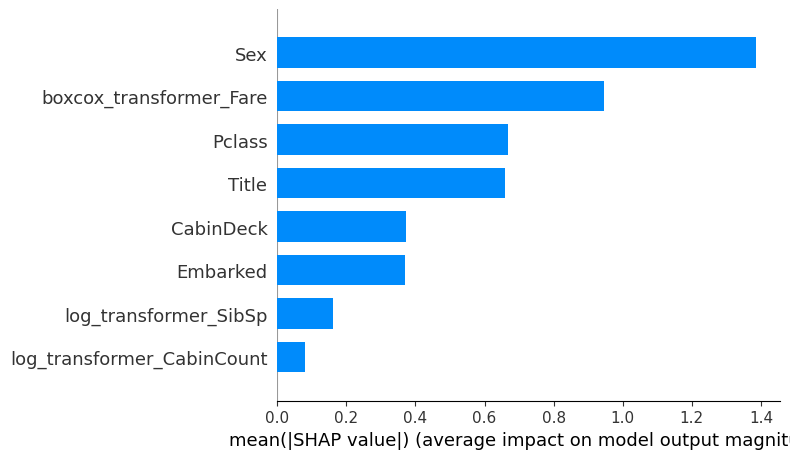

In [ ]:
# Plot feature importance for engineered model
explainer = shap.Explainer(best_model, df_eng_train[top_features_final])
shap_values = explainer(df_eng_val[top_features_final])
print(f"\nSHAP Summary Plot (Top {len(top_features_final)} Features):")
shap.summary_plot(shap_values, df_eng_val[top_features_final], plot_type="bar", max_display=len(top_features_final))


SHAP with Baseline Model Summary Plot:


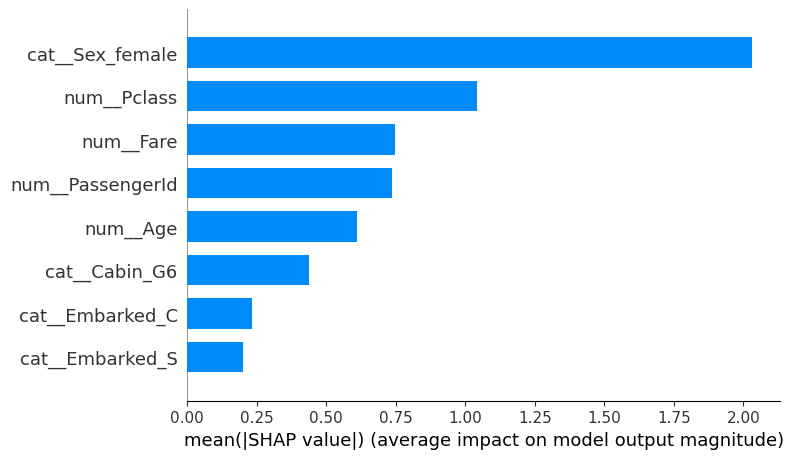

In [ ]:
# Plot feature importance for baseline model
explainer = shap.Explainer(baseline_model, X_train_base_processed)
shap_values = explainer(X_val_base_processed)
print(f"\nSHAP with Baseline Model Summary Plot:")
shap.summary_plot(shap_values, X_val_base_processed, plot_type="bar", max_display=len(top_features_final))

In [98]:
print("\n--- Model Performance Comparison ---")
# Make sure you have the baseline_accuracy variable from the start of your notebook
print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}") 
print(f"Final Model Accuracy:    {best_accuracy:.4f}")
print("------------------------------------")


--- Model Performance Comparison ---
Baseline Model Accuracy: 0.7263
Final Model Accuracy:    0.7989
------------------------------------


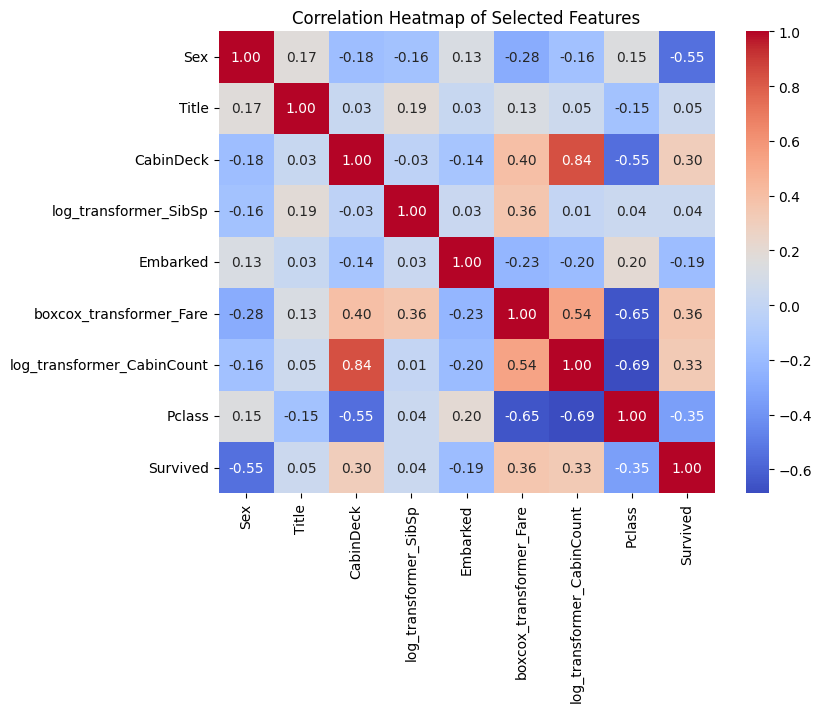

In [99]:
# Show correlation heatmap of the selected features
plt.figure(figsize=(8, 6))
corr_matrix = df_eng_train[top_features_final + ['Survived']].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

## Tune Feature Engineering Model

In [101]:
study = opt.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, df_eng_train[top_features_final], df_eng_train['Survived'], df_eng_val[top_features_final], df_eng_val['Survived']), n_trials=100)

print("\nBest hyperparameters found:")
print(study.best_params)

print("\nBest Accuracy on the test set:")
print(study.best_value)

[I 2025-09-09 02:28:03,658] A new study created in memory with name: no-name-ef5ced5c-b116-445e-a7a5-9cfc1b37c44e
[I 2025-09-09 02:28:04,000] Trial 0 finished with value: 0.7988826815642458 and parameters: {'n_estimators': 900, 'learning_rate': 0.11634532125255559, 'max_depth': 3, 'subsample': 0.7759284435743293, 'colsample_bytree': 0.8780878700170169, 'gamma': 3.0056925031104313, 'lambda': 1.57858027859193, 'alpha': 6.2654617518162965}. Best is trial 0 with value: 0.7988826815642458.
[I 2025-09-09 02:28:04,116] Trial 1 finished with value: 0.7988826815642458 and parameters: {'n_estimators': 300, 'learning_rate': 0.010376321303032567, 'max_depth': 5, 'subsample': 0.8702202003412052, 'colsample_bytree': 0.9941073419805121, 'gamma': 1.2228236674443493, 'lambda': 3.172582817693726, 'alpha': 3.065063919841381}. Best is trial 0 with value: 0.7988826815642458.
[I 2025-09-09 02:28:04,263] Trial 2 finished with value: 0.8044692737430168 and parameters: {'n_estimators': 400, 'learning_rate': 0.


Best hyperparameters found:
{'n_estimators': 600, 'learning_rate': 0.05426751722509664, 'max_depth': 10, 'subsample': 0.8712227740067771, 'colsample_bytree': 0.8257092537074491, 'gamma': 1.197246234181056, 'lambda': 1.694127012676769, 'alpha': 1.4198256381978784}

Best Accuracy on the test set:
0.8435754189944135


In [103]:
# Train engineered model
engineered_model_tuned = xgb.XGBClassifier(
    n_estimators=study.best_params['n_estimators'],
    learning_rate=study.best_params['learning_rate'],
    max_depth=study.best_params['max_depth'],
    subsample=study.best_params['subsample'],
    colsample_bytree=study.best_params['colsample_bytree'],
    gamma=study.best_params['gamma'],
    lambda_=study.best_params['lambda'],
    alpha=study.best_params['alpha'],
    random_state=42,
    eval_metric='logloss'
)

engineered_model_tuned.fit(df_eng_train[top_features_final], df_eng_train['Survived'])

# Evaluate engineered model
preds_base = engineered_model_tuned.predict(df_eng_val[top_features_final])
engineered_tuned_accuracy = accuracy_score(df_eng_val['Survived'], preds_base)

print(f"Engineered Tuned Model Accuracy: {engineered_tuned_accuracy:.4f}")

Engineered Tuned Model Accuracy: 0.8324


c:\Users\arthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:31:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "lambda_" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [105]:
# Compare all models
print("\n--- Model Performance Comparison ---")
print(f"Baseline Model Accuracy:          {baseline_accuracy:.4f}")
print(f"Baseline Tuned Model Accuracy:    {baseline_tuned_accuracy:.4f}")
print(f"Engineered Model Accuracy:        {best_accuracy:.4f}")
print(f"Engineered Tuned Model Accuracy:  {engineered_tuned_accuracy:.4f}")


--- Model Performance Comparison ---
Baseline Model Accuracy:          0.7263
Baseline Tuned Model Accuracy:    0.8212
Engineered Model Accuracy:        0.7989
Engineered Tuned Model Accuracy:  0.8324


## The Law of Diminishing Returns

1. **Untuned Models:** When the models are untuned (using default settings), the one with the better features (Engineered Model) has a clear advantage over the simpler one (Baseline Model). This is because the extra engineered features are providing more useful signals right out of the box.

2. **Tuned Models:** When we apply a powerful optimization tool like Optuna, it is extremely good at squeezing every last drop of predictive power out of the features it's given. The tuner for the baseline model learned how to combine the simple features (Pclass, Sex, Age, Fare) so effectively that it reached a performance level very close to the theoretical maximum for this dataset.